In [2]:
# !pip install -U scikit-learn

In [1]:
import os
import random
import math
import time
from pathlib import Path
from typing import Optional, Tuple, List

import numpy as np
import pandas as pd
import nibabel as nib
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.models.video import r3d_18  # 3D ResNet-18
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

In [2]:
def fix_path(p):
    p = str(p).replace("\\", "/")
    if "preprocessed_fleischner_fixed/" in p:
        p = p.split("preprocessed_fleischner_fixed/")[1]
    return f"../dataset/{p}"

In [3]:
# -------------------------
# CONFIG
# -------------------------
DATA_CSV = "../metadata/augmented_classification_metadata.csv"        # your combined metadata (3600 rows)
IMAGE_KEY = "image"                    # column name with image path
LABEL_KEY = "label_3class"             # column name with numeric labels (0/1/2)
MASK_KEY = "mask"                      # optional mask path column
UID_KEY = "uid"

OUT_DIR = "runs/3d_resnet"
os.makedirs(OUT_DIR, exist_ok=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42

In [4]:
# Model / training hyperparams
NUM_CLASSES = 3
BATCH_SIZE = 8              # reduce if GPU memory is limited
NUM_EPOCHS = 60
LR = 1e-4
WEIGHT_DECAY = 1e-5
NUM_WORKERS = 6
INPUT_SHAPE = (64, 64, 64)  # target patch shape (D,H,W) for the network
CROP_WITH_MASK = True       # If True, crop around mask bounding box then resize; else center-crop
USE_AMP = True              # mixed precision

# Augmentation params (applied on-the-fly in dataset)
AUG_PROB = 0.5
GAUSSIAN_NOISE_STD = 0.01


# Training utilities
BEST_MODEL_PATH = os.path.join(OUT_DIR, "best_model.pth")
LAST_MODEL_PATH = os.path.join(OUT_DIR, "last_model.pth")
LOG_CSV = os.path.join(OUT_DIR, "training_log.csv")


def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

In [5]:
# -------------------------
# HELPERS: load and preprocess
# -------------------------
def load_nii(path: str) -> np.ndarray:
    """Load nii.gz and return numpy array (Z,Y,X) or (D,H,W) as float32."""
    img = nib.load(path)
    arr = img.get_fdata(dtype=np.float32)
    # ensure shape ordering is (D,H,W) consistent with our use (z,y,x)
    # nibabel returns (X, Y, Z) depending — but in our pipeline arr.shape should be (H,W,D) often.
    # We will not transpose blindly; we assume your earlier pipeline ensured consistent orientation and shape.
    # If needed, adjust here.
    if arr.ndim == 4:
        arr = arr[..., 0]
    return arr.astype(np.float32)

def hu_windowing(img: np.ndarray, window_center: int = -600, window_width: int = 1500) -> np.ndarray:
    """Apply HU windowing typical for lung/CT. Adjust center/width if desired."""
    lower = window_center - window_width/2
    upper = window_center + window_width/2
    img = np.clip(img, lower, upper)
    img = (img - lower) / (upper - lower)  # normalize to 0..1
    return img

def resize_vol(vol: np.ndarray, target_shape: Tuple[int,int,int]) -> np.ndarray:
    """Resize using simple np interpolation via scipy if available, fallback to basic cropping/pad."""
    import scipy.ndimage as ndi
    factors = [t / s for s, t in zip(vol.shape, target_shape)]
    vol_resized = ndi.zoom(vol, zoom=factors, order=1)  # linear interpolation
    return vol_resized

def center_crop_or_pad(vol: np.ndarray, target_shape: Tuple[int,int,int]) -> np.ndarray:
    """Center-crop or pad to target_shape (D,H,W)."""
    out = np.zeros(target_shape, dtype=vol.dtype)
    dz, dh, dw = vol.shape
    td, th, tw = target_shape
    # compute start indices
    sd = max(0, (dz - td)//2)
    sh = max(0, (dh - th)//2)
    sw = max(0, (dw - tw)//2)
    ed = sd + min(td, dz)
    eh = sh + min(th, dh)
    ew = sw + min(tw, dw)
    out_sd = max(0, (td - dz)//2)
    out_sh = max(0, (th - dh)//2)
    out_sw = max(0, (tw - dw)//2)
    out[out_sd:out_sd+(ed-sd), out_sh:out_sh+(eh-sh), out_sw:out_sw+(ew-sw)] = vol[sd:ed, sh:eh, sw:ew]
    return out

def crop_around_mask(image: np.ndarray, mask: np.ndarray, margin: int = 6, target_shape: Tuple[int,int,int]=(64,64,64)) -> np.ndarray:
    """Crop tight bounding box around mask then center-pad/crop to target shape."""
    coords = np.argwhere(mask > 0)
    if coords.size == 0:
        # fallback to center crop
        return center_crop_or_pad(image, target_shape)
    zmin, ymin, xmin = coords.min(axis=0)
    zmax, ymax, xmax = coords.max(axis=0)
    zmin = max(0, zmin - margin); ymin = max(0, ymin - margin); xmin = max(0, xmin - margin)
    zmax = min(image.shape[0]-1, zmax + margin); ymax = min(image.shape[1]-1, ymax + margin); xmax = min(image.shape[2]-1, xmax + margin)
    cropped = image[zmin:zmax+1, ymin:ymax+1, xmin:xmax+1]
    # resize or pad to target
    if cropped.shape != target_shape:
        cropped = resize_vol(cropped, target_shape)
    return cropped

In [6]:
# -------------------------
# DATASET
# -------------------------
class NiiDataset(Dataset):
    def __init__(self, df: pd.DataFrame, image_col: str = IMAGE_KEY, label_col: str = LABEL_KEY,
                 mask_col: Optional[str] = MASK_KEY, input_shape: Tuple[int,int,int]=INPUT_SHAPE,
                 augment: bool=True):
        self.df = df.reset_index(drop=True)
        self.image_col = image_col
        self.label_col = label_col
        self.mask_col = mask_col if mask_col in df.columns else None
        self.input_shape = input_shape
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def random_flip(self, vol: np.ndarray) -> np.ndarray:
        if random.random() < 0.5:
            # random axis flip
            axes = []
            if random.random() < 0.5: axes.append(0)
            if random.random() < 0.5: axes.append(1)
            if random.random() < 0.5: axes.append(2)
            for a in axes:
                vol = np.flip(vol, axis=a).copy()
        return vol

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row[self.image_col]
        label = int(row[self.label_col])

        img = load_nii(img_path)   # numpy (D,H,W)

        # apply HU windowing and normalization
        img = hu_windowing(img)    # values 0..1

        # optional mask-based crop for ROI
        if self.mask_col and pd.notna(row.get(self.mask_col, None)) and CROP_WITH_MASK:
            mask_path = row[self.mask_col]
            try:
                mask = load_nii(mask_path)
            except Exception:
                mask = np.zeros_like(img)
            img = crop_around_mask(img, mask, margin=6, target_shape=self.input_shape)
        else:
            # center crop/pad to desired shape, or resize
            if img.shape != self.input_shape:
                # try resize first if shapes are similar; else center crop/pad
                try:
                    img = resize_vol(img, self.input_shape)
                except Exception:
                    img = center_crop_or_pad(img, self.input_shape)

        # augmentations (on-the-fly)
        if self.augment:
            if random.random() < AUG_PROB:
                img = self.random_flip(img)
            if random.random() < AUG_PROB:
                # small intensity noise
                img = img + np.random.normal(0, GAUSSIAN_NOISE_STD, size=img.shape).astype(np.float32)
                img = np.clip(img, 0.0, 1.0)

        # standardize (0..1 -> mean/std)
        img = (img - img.mean()) / (img.std() + 1e-8)

        # convert to channel-first torch tensor: (C=1, D, H, W)
        tensor = torch.from_numpy(img).unsqueeze(0).float()

        return tensor, label

In [7]:
# -------------------------
# HELPERS: split + samplers
# -------------------------
def stratified_split(df: pd.DataFrame, val_frac: float = 0.15, seed: int = SEED):
    # simple stratified split by label_3class
    np.random.seed(seed)
    train_idxs = []
    val_idxs = []
    for lbl in sorted(df[LABEL_KEY].unique()):
        idxs = df[df[LABEL_KEY] == lbl].index.values
        np.random.shuffle(idxs)
        n_val = max(1, int(len(idxs) * val_frac))
        val_idxs.extend(list(idxs[:n_val]))
        train_idxs.extend(list(idxs[n_val:]))
    return df.loc[train_idxs].reset_index(drop=True), df.loc[val_idxs].reset_index(drop=True)

def make_weighted_sampler(df: pd.DataFrame, label_col: str = LABEL_KEY):
    labels = df[label_col].values
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    # weight for each class = 1 / count
    weight_per_class = 1.0 / class_sample_count
    weights = weight_per_class[labels]
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    return sampler

In [8]:
# -------------------------
# MODEL
# -------------------------
def build_model(num_classes: int = NUM_CLASSES, pretrained: bool = False) -> nn.Module:
    model = r3d_18(pretrained=pretrained)
    # r3d_18 expects input (B, C=3, T, H, W). We have single-channel volumes; adjust first conv.
    # Replace conv1 to accept 1 channel
    old_conv = model.stem[0]
    new_conv = nn.Conv3d(1, old_conv.out_channels,
                         kernel_size=old_conv.kernel_size,
                         stride=old_conv.stride,
                         padding=old_conv.padding,
                         bias=False)
    # initialize from old conv by averaging weights across channels if pretrained available
    if pretrained:
        new_conv.weight.data = old_conv.weight.data.mean(dim=1, keepdim=True)
    model.stem[0] = new_conv

    # replace final FC
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

In [9]:
# -------------------------
# TRAIN & VALID LOOP
# -------------------------
def train_epoch(model, loader, criterion, optimizer, scaler=None):
    model.train()
    losses = []
    all_preds = []
    all_targets = []

    pbar = tqdm(loader, desc="Train", leave=False)
    for x, y in pbar:
        x = x.to(DEVICE)
        y = y.to(DEVICE, dtype=torch.long)
        optimizer.zero_grad()
        if USE_AMP and scaler is not None:
            with torch.cuda.amp.autocast():
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

        losses.append(loss.item())
        preds = logits.detach().argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(y.cpu().numpy())
        pbar.set_postfix(loss=np.mean(losses), acc=accuracy_score(all_targets, all_preds))

    return np.mean(losses), all_targets, all_preds


def validate_epoch(model, loader, criterion):
    model.eval()
    losses = []
    all_preds = []
    all_targets = []
    with torch.no_grad():
        pbar = tqdm(loader, desc="Valid", leave=False)
        for x, y in pbar:
            x = x.to(DEVICE)
            y = y.to(DEVICE, dtype=torch.long)
            logits = model(x)
            loss = criterion(logits, y)
            losses.append(loss.item())
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(y.cpu().numpy())
            pbar.set_postfix(loss=np.mean(losses), acc=accuracy_score(all_targets, all_preds))
    return np.mean(losses), all_targets, all_preds

In [10]:
# -------------------------
# MAIN
# -------------------------
def main():
    df = pd.read_csv(DATA_CSV)
    df['image'] = df['image'].apply(fix_path)
    df['mask'] = df['mask'].apply(fix_path)
    # ensure labels are integers 0..2
    if df[LABEL_KEY].dtype != int and df[LABEL_KEY].dtype != np.int64:
        df[LABEL_KEY] = df[LABEL_KEY].astype(int)

    # split
    train_df, val_df = stratified_split(df, val_frac=0.15)
    print("Train:", len(train_df), "Val:", len(val_df))

    # datasets
    train_ds = NiiDataset(train_df, augment=True)
    val_ds   = NiiDataset(val_df, augment=False)

    # sampler to rebalance within each epoch
    sampler = make_weighted_sampler(train_df)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                              num_workers=NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=NUM_WORKERS, pin_memory=True)

    model = build_model(num_classes=NUM_CLASSES, pretrained=False).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

    scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP and DEVICE.startswith("cuda"))

    best_val_loss = 1e9
    logs = []

    for epoch in range(1, NUM_EPOCHS+1):
        t0 = time.time()
        train_loss, train_targets, train_preds = train_epoch(model, train_loader, criterion, optimizer, scaler)
        val_loss, val_targets, val_preds = validate_epoch(model, val_loader, criterion)
        scheduler.step()

        # metrics
        train_acc = accuracy_score(train_targets, train_preds)
        val_acc = accuracy_score(val_targets, val_preds)
        p, r, f1, _ = precision_recall_fscore_support(val_targets, val_preds, average='weighted', zero_division=0)
        cm = confusion_matrix(val_targets, val_preds)

        elapsed = time.time() - t0
        print(f"Epoch {epoch}/{NUM_EPOCHS} | train_loss={train_loss:.4f} val_loss={val_loss:.4f} train_acc={train_acc:.4f} val_acc={val_acc:.4f} time={elapsed:.1f}s")
        print("Val: precision, recall, f1 (weighted):", f"{p:.4f}, {r:.4f}, {f1:.4f}")
        print("Confusion matrix:\n", cm)

        logs.append({
            "epoch": epoch, "train_loss": train_loss, "val_loss": val_loss,
            "train_acc": train_acc, "val_acc": val_acc, "precision": p, "recall": r, "f1": f1
        })
        pd.DataFrame(logs).to_csv(LOG_CSV, index=False)

        # save last
        torch.save({"epoch": epoch, "model_state": model.state_dict(), "optimizer": optimizer.state_dict()},
                   LAST_MODEL_PATH)

        # save best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({"epoch": epoch, "model_state": model.state_dict(), "optimizer": optimizer.state_dict()},
                       BEST_MODEL_PATH)
            print("=> saved best model")

    print("Training finished. Best val loss:", best_val_loss)
    print("Best model saved to:", BEST_MODEL_PATH)

In [11]:
main()

Train: 2550 Val: 450


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/60 | train_loss=1.0686 val_loss=0.9830 train_acc=0.4133 val_acc=0.4889 time=20.4s
Val: precision, recall, f1 (weighted): 0.4584, 0.4889, 0.4256
Confusion matrix:
 [[134  16   0]
 [ 58  73  19]
 [ 44  93  13]]
=> saved best model


Epoch 2/60 | train_loss=0.9749 val_loss=0.9039 train_acc=0.4945 val_acc=0.5578 time=19.9s
Val: precision, recall, f1 (weighted): 0.5695, 0.5578, 0.4989
Confusion matrix:
 [[115   4  31]
 [ 33  16 101]
 [ 21   9 120]]
=> saved best model


Epoch 3/60 | train_loss=0.9258 val_loss=0.9606 train_acc=0.5235 val_acc=0.5111 time=20.0s
Val: precision, recall, f1 (weighted): 0.6137, 0.5111, 0.4367
Confusion matrix:
 [[104  46   0]
 [ 27 121   2]
 [ 13 132   5]]


Epoch 4/60 | train_loss=0.9155 val_loss=0.8383 train_acc=0.5192 val_acc=0.5933 time=19.9s
Val: precision, recall, f1 (weighted): 0.5805, 0.5933, 0.5794
Confusion matrix:
 [[126   7  17]
 [ 32  51  67]
 [ 16  44  90]]
=> saved best model


Epoch 5/60 | train_loss=0.8955 val_loss=0.8969 train_acc=0.5494 val_acc=0.5400 time=19.9s
Val: precision, recall, f1 (weighted): 0.5258, 0.5400, 0.4872
Confusion matrix:
 [[124  23   3]
 [ 29 104  17]
 [ 19 116  15]]


Epoch 6/60 | train_loss=0.8811 val_loss=0.8201 train_acc=0.5447 val_acc=0.5667 time=19.9s
Val: precision, recall, f1 (weighted): 0.5671, 0.5667, 0.5667
Confusion matrix:
 [[116  21  13]
 [ 23  61  66]
 [  9  63  78]]
=> saved best model


Epoch 7/60 | train_loss=0.8754 val_loss=0.8426 train_acc=0.5643 val_acc=0.5800 time=19.9s
Val: precision, recall, f1 (weighted): 0.5722, 0.5800, 0.5671
Confusion matrix:
 [[127  15   8]
 [ 35  78  37]
 [ 23  71  56]]


Epoch 8/60 | train_loss=0.8568 val_loss=0.8218 train_acc=0.5824 val_acc=0.5822 time=19.9s
Val: precision, recall, f1 (weighted): 0.5758, 0.5822, 0.5699
Confusion matrix:
 [[126  14  10]
 [ 33  82  35]
 [ 19  77  54]]


Epoch 9/60 | train_loss=0.8734 val_loss=0.8302 train_acc=0.5529 val_acc=0.5933 time=19.9s
Val: precision, recall, f1 (weighted): 0.5752, 0.5933, 0.5681
Confusion matrix:
 [[127  13  10]
 [ 34  40  76]
 [ 22  28 100]]


Epoch 10/60 | train_loss=0.8652 val_loss=0.8389 train_acc=0.5616 val_acc=0.5578 time=19.8s
Val: precision, recall, f1 (weighted): 0.6224, 0.5578, 0.5232
Confusion matrix:
 [[105  42   3]
 [ 13 124  13]
 [  4 124  22]]


Epoch 11/60 | train_loss=0.8496 val_loss=0.8148 train_acc=0.5753 val_acc=0.6000 time=20.0s
Val: precision, recall, f1 (weighted): 0.6046, 0.6000, 0.5953
Confusion matrix:
 [[109  30  11]
 [ 17  53  80]
 [  6  36 108]]
=> saved best model


Epoch 12/60 | train_loss=0.8316 val_loss=0.7706 train_acc=0.5831 val_acc=0.6356 time=19.9s
Val: precision, recall, f1 (weighted): 0.6356, 0.6356, 0.6351
Confusion matrix:
 [[121  15  14]
 [ 21  73  56]
 [  6  52  92]]
=> saved best model


Epoch 13/60 | train_loss=0.8218 val_loss=0.7975 train_acc=0.5918 val_acc=0.6067 time=19.9s
Val: precision, recall, f1 (weighted): 0.5934, 0.6067, 0.5898
Confusion matrix:
 [[126  10  14]
 [ 33  49  68]
 [ 16  36  98]]


Epoch 14/60 | train_loss=0.8269 val_loss=0.8209 train_acc=0.5773 val_acc=0.5822 time=19.8s
Val: precision, recall, f1 (weighted): 0.5983, 0.5822, 0.5683
Confusion matrix:
 [[119  25   6]
 [ 29  97  24]
 [ 15  89  46]]


Epoch 15/60 | train_loss=0.8461 val_loss=0.7902 train_acc=0.5808 val_acc=0.6422 time=19.9s
Val: precision, recall, f1 (weighted): 0.6780, 0.6422, 0.6180
Confusion matrix:
 [[110  14  26]
 [ 15  42  93]
 [  4   9 137]]


Epoch 16/60 | train_loss=0.8310 val_loss=0.7852 train_acc=0.5902 val_acc=0.6111 time=19.9s
Val: precision, recall, f1 (weighted): 0.6000, 0.6111, 0.5625
Confusion matrix:
 [[125   8  17]
 [ 30  24  96]
 [  9  15 126]]


Epoch 17/60 | train_loss=0.8013 val_loss=0.7432 train_acc=0.5965 val_acc=0.6511 time=20.0s
Val: precision, recall, f1 (weighted): 0.6520, 0.6511, 0.6460
Confusion matrix:
 [[128  16   6]
 [ 33  87  30]
 [ 14  58  78]]
=> saved best model


Epoch 18/60 | train_loss=0.8067 val_loss=0.8098 train_acc=0.5906 val_acc=0.6067 time=19.9s
Val: precision, recall, f1 (weighted): 0.5998, 0.6067, 0.5933
Confusion matrix:
 [[118  15  17]
 [ 27  49  74]
 [ 10  34 106]]


Epoch 19/60 | train_loss=0.7892 val_loss=0.7815 train_acc=0.6047 val_acc=0.6044 time=19.9s
Val: precision, recall, f1 (weighted): 0.6470, 0.6044, 0.6069
Confusion matrix:
 [[104  39   7]
 [ 12 107  31]
 [  5  84  61]]


Epoch 20/60 | train_loss=0.7799 val_loss=0.7793 train_acc=0.6071 val_acc=0.6289 time=20.0s
Val: precision, recall, f1 (weighted): 0.6256, 0.6289, 0.6237
Confusion matrix:
 [[127  16   7]
 [ 34  79  37]
 [ 12  61  77]]


Epoch 21/60 | train_loss=0.7808 val_loss=0.8347 train_acc=0.6239 val_acc=0.6133 time=19.9s
Val: precision, recall, f1 (weighted): 0.6694, 0.6133, 0.6250
Confusion matrix:
 [[93 50  7]
 [ 8 99 43]
 [ 0 66 84]]


Epoch 22/60 | train_loss=0.7372 val_loss=0.7553 train_acc=0.6514 val_acc=0.6444 time=19.9s
Val: precision, recall, f1 (weighted): 0.6569, 0.6444, 0.6451
Confusion matrix:
 [[118  25   7]
 [ 19  97  34]
 [  9  66  75]]


Epoch 23/60 | train_loss=0.7760 val_loss=0.7782 train_acc=0.6318 val_acc=0.6333 time=19.9s
Val: precision, recall, f1 (weighted): 0.6536, 0.6333, 0.6399
Confusion matrix:
 [[107  38   5]
 [ 17  89  44]
 [  5  56  89]]


Epoch 24/60 | train_loss=0.7241 val_loss=0.7409 train_acc=0.6475 val_acc=0.6644 time=19.9s
Val: precision, recall, f1 (weighted): 0.6740, 0.6644, 0.6643
Confusion matrix:
 [[109  28  13]
 [ 16  75  59]
 [  3  32 115]]
=> saved best model


Epoch 25/60 | train_loss=0.7530 val_loss=0.7806 train_acc=0.6463 val_acc=0.6333 time=19.9s
Val: precision, recall, f1 (weighted): 0.6398, 0.6333, 0.6222
Confusion matrix:
 [[112  26  12]
 [ 15  51  84]
 [  4  24 122]]


Epoch 26/60 | train_loss=0.7104 val_loss=0.7633 train_acc=0.6682 val_acc=0.6911 time=19.8s
Val: precision, recall, f1 (weighted): 0.6969, 0.6911, 0.6841
Confusion matrix:
 [[115  22  13]
 [ 18  70  62]
 [  6  18 126]]


Epoch 27/60 | train_loss=0.7273 val_loss=0.7602 train_acc=0.6478 val_acc=0.6422 time=20.0s
Val: precision, recall, f1 (weighted): 0.6651, 0.6422, 0.6444
Confusion matrix:
 [[115  33   2]
 [ 23  98  29]
 [  8  66  76]]


Epoch 28/60 | train_loss=0.7184 val_loss=0.7411 train_acc=0.6620 val_acc=0.6689 time=19.9s
Val: precision, recall, f1 (weighted): 0.6889, 0.6689, 0.6731
Confusion matrix:
 [[113  33   4]
 [ 19 101  30]
 [  6  57  87]]


Epoch 29/60 | train_loss=0.7113 val_loss=0.7299 train_acc=0.6643 val_acc=0.6756 time=19.9s
Val: precision, recall, f1 (weighted): 0.6878, 0.6756, 0.6726
Confusion matrix:
 [[112  28  10]
 [ 12  69  69]
 [  2  25 123]]
=> saved best model


Epoch 30/60 | train_loss=0.7113 val_loss=0.7609 train_acc=0.6671 val_acc=0.6778 time=19.9s
Val: precision, recall, f1 (weighted): 0.6752, 0.6778, 0.6607
Confusion matrix:
 [[121  20   9]
 [ 24  54  72]
 [  1  19 130]]


Epoch 31/60 | train_loss=0.6984 val_loss=0.7726 train_acc=0.6773 val_acc=0.6711 time=19.9s
Val: precision, recall, f1 (weighted): 0.6778, 0.6711, 0.6567
Confusion matrix:
 [[116  20  14]
 [ 20  55  75]
 [  0  19 131]]


Epoch 32/60 | train_loss=0.6420 val_loss=0.8239 train_acc=0.7102 val_acc=0.6467 time=19.9s
Val: precision, recall, f1 (weighted): 0.6806, 0.6467, 0.6534
Confusion matrix:
 [[107  41   2]
 [ 17 102  31]
 [  4  64  82]]


Epoch 33/60 | train_loss=0.6557 val_loss=0.7613 train_acc=0.6878 val_acc=0.6800 time=19.9s
Val: precision, recall, f1 (weighted): 0.6843, 0.6800, 0.6809
Confusion matrix:
 [[113  31   6]
 [ 21  81  48]
 [  2  36 112]]


Epoch 34/60 | train_loss=0.6438 val_loss=0.7271 train_acc=0.7039 val_acc=0.6867 time=19.8s
Val: precision, recall, f1 (weighted): 0.6999, 0.6867, 0.6905
Confusion matrix:
 [[111  32   7]
 [ 14  87  49]
 [  1  38 111]]
=> saved best model


Epoch 35/60 | train_loss=0.6093 val_loss=0.7668 train_acc=0.7176 val_acc=0.6556 time=19.9s
Val: precision, recall, f1 (weighted): 0.6525, 0.6556, 0.6538
Confusion matrix:
 [[120  21   9]
 [ 28  77  45]
 [  7  45  98]]


Epoch 36/60 | train_loss=0.6125 val_loss=0.7514 train_acc=0.7094 val_acc=0.6911 time=19.9s
Val: precision, recall, f1 (weighted): 0.6956, 0.6911, 0.6902
Confusion matrix:
 [[116  23  11]
 [ 18  79  53]
 [  2  32 116]]


Epoch 37/60 | train_loss=0.6190 val_loss=0.7519 train_acc=0.7055 val_acc=0.6711 time=19.9s
Val: precision, recall, f1 (weighted): 0.6613, 0.6711, 0.6579
Confusion matrix:
 [[120  21   9]
 [ 36  61  53]
 [  7  22 121]]


Epoch 38/60 | train_loss=0.6167 val_loss=0.7645 train_acc=0.7180 val_acc=0.7044 time=19.9s
Val: precision, recall, f1 (weighted): 0.7102, 0.7044, 0.7041
Confusion matrix:
 [[111  33   6]
 [ 17  84  49]
 [  2  26 122]]


Epoch 39/60 | train_loss=0.6095 val_loss=0.8112 train_acc=0.7169 val_acc=0.6889 time=19.9s
Val: precision, recall, f1 (weighted): 0.7100, 0.6889, 0.6949
Confusion matrix:
 [[109  38   3]
 [ 16 101  33]
 [  3  47 100]]


Epoch 40/60 | train_loss=0.5787 val_loss=0.7834 train_acc=0.7510 val_acc=0.7089 time=19.9s
Val: precision, recall, f1 (weighted): 0.7121, 0.7089, 0.7047
Confusion matrix:
 [[115  26   9]
 [ 19  77  54]
 [  1  22 127]]


Epoch 41/60 | train_loss=0.5984 val_loss=0.7197 train_acc=0.7173 val_acc=0.7000 time=19.9s
Val: precision, recall, f1 (weighted): 0.6934, 0.7000, 0.6949
Confusion matrix:
 [[124  20   6]
 [ 31  77  42]
 [  5  31 114]]
=> saved best model


Epoch 42/60 | train_loss=0.5657 val_loss=0.7717 train_acc=0.7443 val_acc=0.7067 time=19.9s
Val: precision, recall, f1 (weighted): 0.7009, 0.7067, 0.7017
Confusion matrix:
 [[122  23   5]
 [ 28  78  44]
 [  6  26 118]]


Epoch 43/60 | train_loss=0.5522 val_loss=0.7443 train_acc=0.7486 val_acc=0.7133 time=19.9s
Val: precision, recall, f1 (weighted): 0.7115, 0.7133, 0.7123
Confusion matrix:
 [[123  23   4]
 [ 24  90  36]
 [  9  33 108]]


Epoch 44/60 | train_loss=0.5523 val_loss=0.7974 train_acc=0.7486 val_acc=0.7044 time=20.0s
Val: precision, recall, f1 (weighted): 0.7036, 0.7044, 0.7039
Confusion matrix:
 [[119  26   5]
 [ 24  87  39]
 [  6  33 111]]


Epoch 45/60 | train_loss=0.5438 val_loss=0.7852 train_acc=0.7502 val_acc=0.6756 time=19.9s
Val: precision, recall, f1 (weighted): 0.6800, 0.6756, 0.6773
Confusion matrix:
 [[115  30   5]
 [ 22  83  45]
 [  3  41 106]]


Epoch 46/60 | train_loss=0.5440 val_loss=0.7654 train_acc=0.7482 val_acc=0.7178 time=19.9s
Val: precision, recall, f1 (weighted): 0.7281, 0.7178, 0.7213
Confusion matrix:
 [[114  33   3]
 [ 17 100  33]
 [  4  37 109]]


Epoch 47/60 | train_loss=0.5303 val_loss=0.7873 train_acc=0.7561 val_acc=0.6867 time=20.0s
Val: precision, recall, f1 (weighted): 0.6822, 0.6867, 0.6826
Confusion matrix:
 [[118  26   6]
 [ 25  77  48]
 [ 10  26 114]]


Epoch 48/60 | train_loss=0.5496 val_loss=0.7830 train_acc=0.7353 val_acc=0.7044 time=19.9s
Val: precision, recall, f1 (weighted): 0.7117, 0.7044, 0.7073
Confusion matrix:
 [[118  29   3]
 [ 18  94  38]
 [  4  41 105]]


Epoch 49/60 | train_loss=0.5314 val_loss=0.8530 train_acc=0.7482 val_acc=0.6911 time=20.0s
Val: precision, recall, f1 (weighted): 0.6950, 0.6911, 0.6927
Confusion matrix:
 [[117  27   6]
 [ 21  87  42]
 [  3  40 107]]


Epoch 50/60 | train_loss=0.5275 val_loss=0.7943 train_acc=0.7549 val_acc=0.6933 time=19.8s
Val: precision, recall, f1 (weighted): 0.6883, 0.6933, 0.6880
Confusion matrix:
 [[118  27   5]
 [ 26  74  50]
 [  5  25 120]]


Epoch 51/60 | train_loss=0.5184 val_loss=0.8216 train_acc=0.7573 val_acc=0.7022 time=19.9s
Val: precision, recall, f1 (weighted): 0.7093, 0.7022, 0.7043
Confusion matrix:
 [[114  32   4]
 [ 17  88  45]
 [  2  34 114]]


Epoch 52/60 | train_loss=0.5270 val_loss=0.8254 train_acc=0.7467 val_acc=0.6956 time=19.9s
Val: precision, recall, f1 (weighted): 0.6986, 0.6956, 0.6964
Confusion matrix:
 [[115  31   4]
 [ 21  85  44]
 [  3  34 113]]


Epoch 53/60 | train_loss=0.5303 val_loss=0.8262 train_acc=0.7588 val_acc=0.7000 time=19.8s
Val: precision, recall, f1 (weighted): 0.6961, 0.7000, 0.6972
Confusion matrix:
 [[119  26   5]
 [ 27  81  42]
 [  6  29 115]]


Epoch 54/60 | train_loss=0.4970 val_loss=0.7984 train_acc=0.7722 val_acc=0.7000 time=19.9s
Val: precision, recall, f1 (weighted): 0.7076, 0.7000, 0.7029
Confusion matrix:
 [[116  30   4]
 [ 16  93  41]
 [  5  39 106]]


Epoch 55/60 | train_loss=0.5194 val_loss=0.8031 train_acc=0.7557 val_acc=0.7067 time=19.9s
Val: precision, recall, f1 (weighted): 0.7053, 0.7067, 0.7058
Confusion matrix:
 [[120  26   4]
 [ 23  86  41]
 [  6  32 112]]


Epoch 56/60 | train_loss=0.5000 val_loss=0.8077 train_acc=0.7659 val_acc=0.7044 time=20.0s
Val: precision, recall, f1 (weighted): 0.7045, 0.7044, 0.7042
Confusion matrix:
 [[118  28   4]
 [ 22  86  42]
 [  5  32 113]]


Epoch 57/60 | train_loss=0.5147 val_loss=0.7962 train_acc=0.7584 val_acc=0.6956 time=19.9s
Val: precision, recall, f1 (weighted): 0.7023, 0.6956, 0.6983
Confusion matrix:
 [[118  29   3]
 [ 18  92  40]
 [  5  42 103]]


Epoch 58/60 | train_loss=0.4999 val_loss=0.7905 train_acc=0.7675 val_acc=0.7067 time=19.9s
Val: precision, recall, f1 (weighted): 0.7073, 0.7067, 0.7069
Confusion matrix:
 [[120  27   3]
 [ 22  87  41]
 [  4  35 111]]


Epoch 59/60 | train_loss=0.5091 val_loss=0.7843 train_acc=0.7667 val_acc=0.7089 time=19.9s
Val: precision, recall, f1 (weighted): 0.7068, 0.7089, 0.7076
Confusion matrix:
 [[120  27   3]
 [ 24  86  40]
 [  7  30 113]]


Epoch 60/60 | train_loss=0.5118 val_loss=0.7902 train_acc=0.7627 val_acc=0.7200 time=19.9s
Val: precision, recall, f1 (weighted): 0.7182, 0.7200, 0.7183
Confusion matrix:
 [[120  26   4]
 [ 22  86  42]
 [  5  27 118]]
Training finished. Best val loss: 0.7197167776655733
Best model saved to: runs/3d_resnet/best_model.pth


Found 1815 augmented samples.


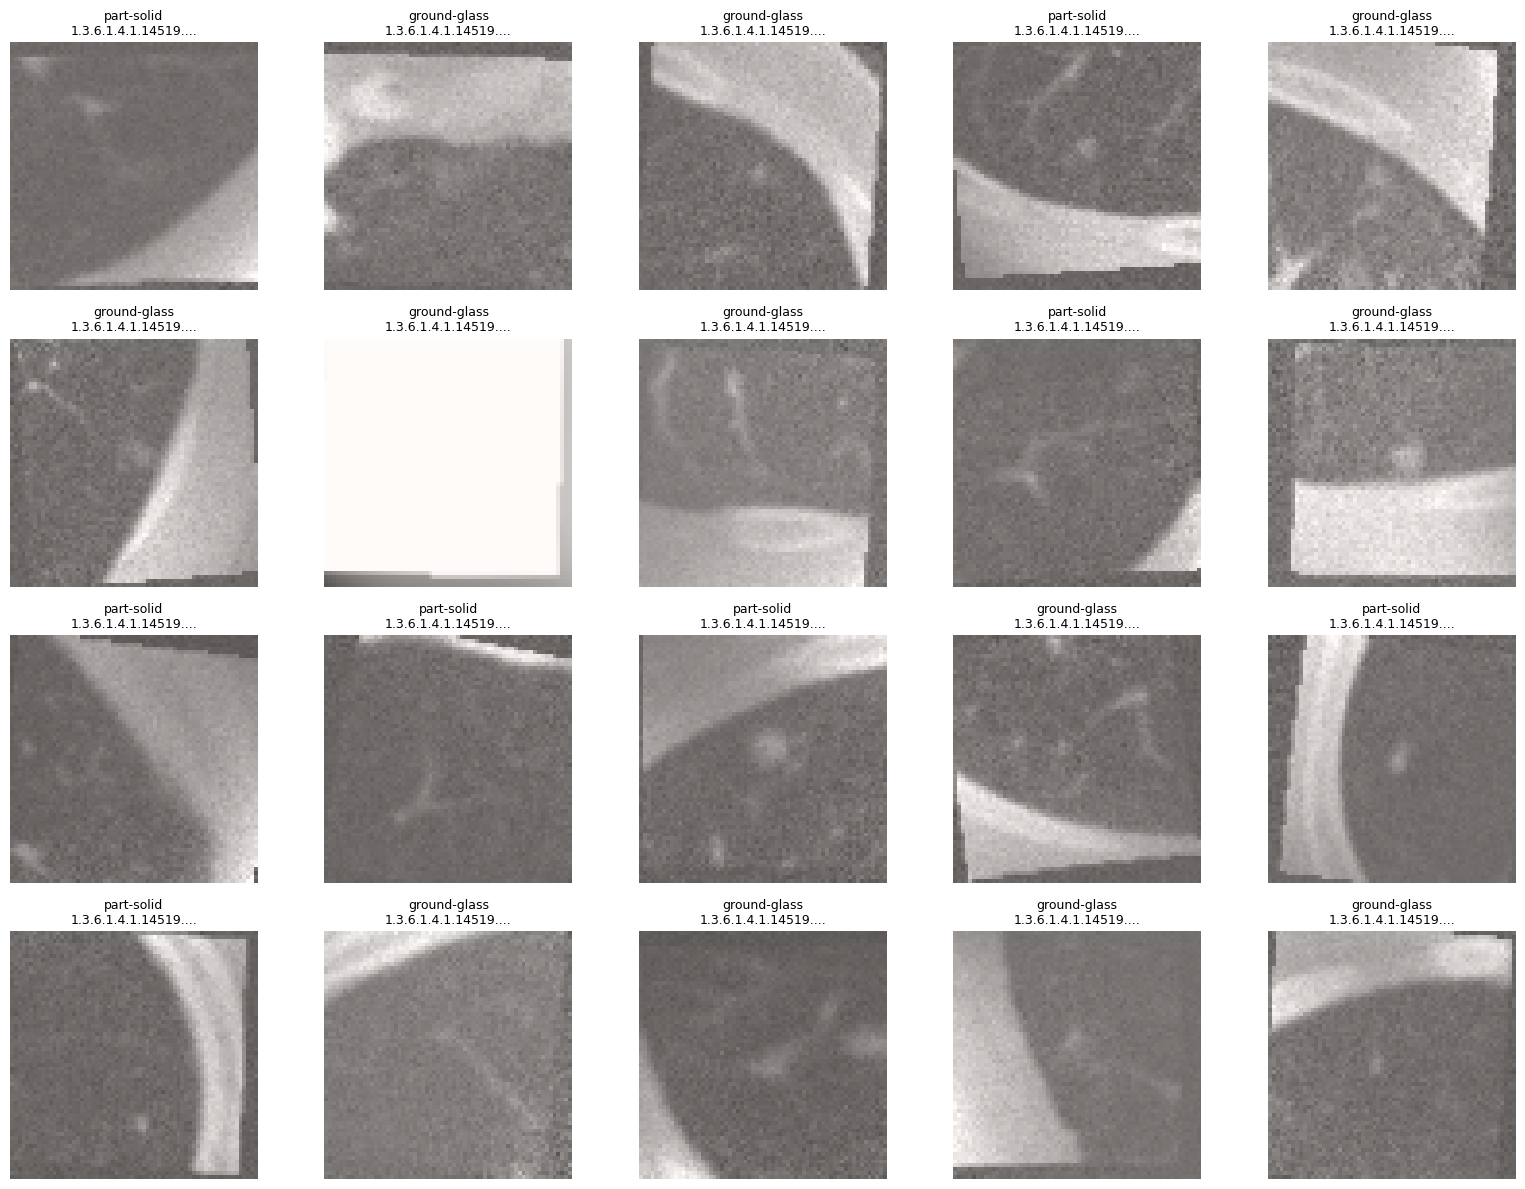

In [12]:
import os
import random
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

AUG_DIR = "../dataset/augmented"
CLASSES = ["ground-glass", "part-solid", "solid"]

def load_nii(path):
    return nib.load(path).get_fdata()

# ------------------------------
# COLLECT ALL AUGMENTED SAMPLES
# ------------------------------
samples = []

for cls in CLASSES:
    class_dir = os.path.join(AUG_DIR, cls)
    for f in os.listdir(class_dir):
        if f.endswith(".nii.gz") and "_aug_" in f and not f.endswith("_mask.nii.gz"):
            img_path = os.path.join(class_dir, f)
            mask_path = img_path.replace(".nii.gz", "_mask.nii.gz")
            samples.append((cls, img_path, mask_path))

print(f"Found {len(samples)} augmented samples.")

# RANDOMLY SELECT 20
chosen = random.sample(samples, 20)

# ------------------------------
# VISUALIZE IN 4 × 5 GRID
# ------------------------------
fig, axes = plt.subplots(4, 5, figsize=(16, 12))
axes = axes.flatten()

for ax, (cls, img_path, mask_path) in zip(axes, chosen):

    # Load CT & mask
    img = load_nii(img_path)
    mask = load_nii(mask_path)

    # Pick center slice along Z-axis
    z = img.shape[2] // 2
    img_slice = img[:, :, z]
    mask_slice = mask[:, :, z]

    # Normalize image for display
    img_disp = img_slice
    if img_disp.max() > 0:
        img_disp = img_disp / img_disp.max()

    # Plot
    ax.imshow(img_disp, cmap="gray")
    ax.imshow(mask_slice, alpha=0.35, cmap="Reds")  # overlay

    title = f"{cls}\n{os.path.basename(img_path)[:18]}..."
    ax.set_title(title, fontsize=9)
    ax.axis("off")

plt.tight_layout()
plt.show()


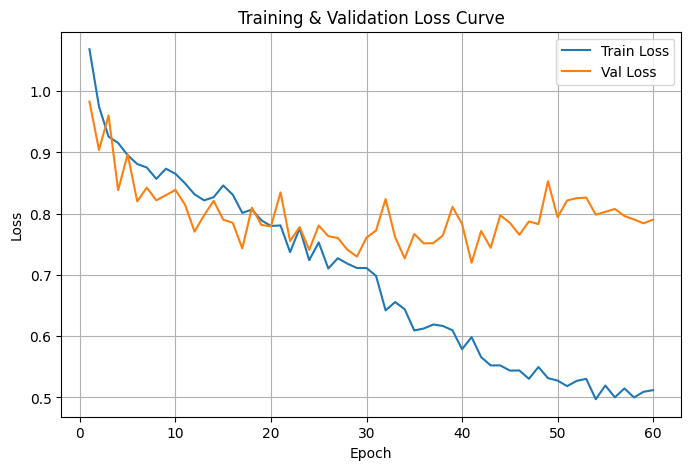

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

log = pd.read_csv("runs/3d_resnet/training_log.csv")

plt.figure(figsize=(8,5))
plt.plot(log["epoch"], log["train_loss"], label="Train Loss")
plt.plot(log["epoch"], log["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.savefig("loss_curve_resnet.png", dpi=300, bbox_inches='tight')
plt.show()


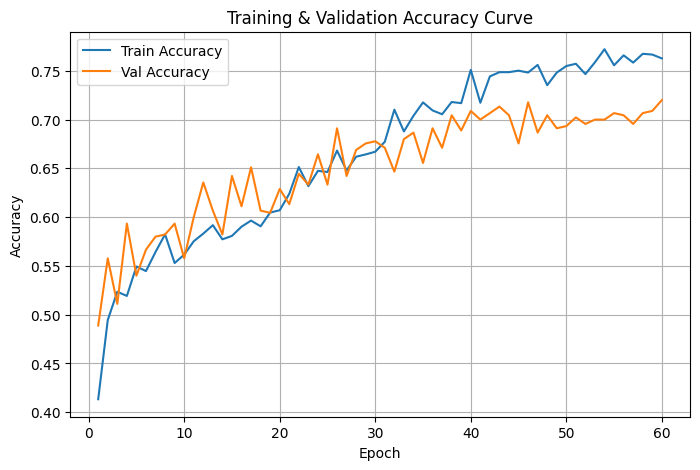

In [14]:
plt.figure(figsize=(8,5))
plt.plot(log["epoch"], log["train_acc"], label="Train Accuracy")
plt.plot(log["epoch"], log["val_acc"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy Curve")
plt.legend()
plt.grid(True)
plt.savefig("accuracy_curve.png", dpi=300, bbox_inches='tight')
plt.show()


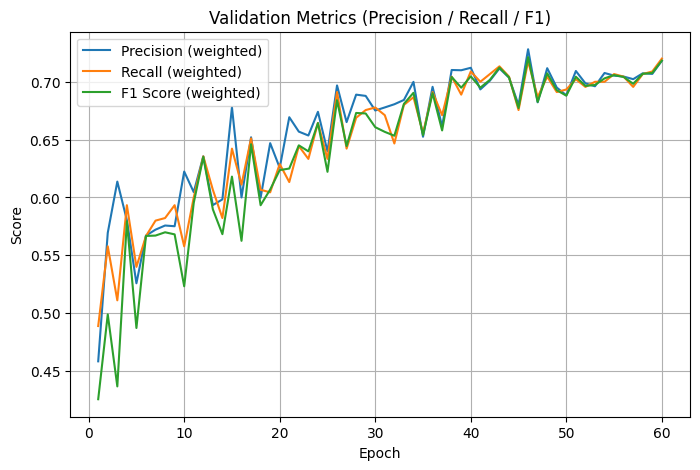

In [15]:
plt.figure(figsize=(8,5))
plt.plot(log["epoch"], log["precision"], label="Precision (weighted)")
plt.plot(log["epoch"], log["recall"], label="Recall (weighted)")
plt.plot(log["epoch"], log["f1"], label="F1 Score (weighted)")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Metrics (Precision / Recall / F1)")
plt.legend()
plt.grid(True)
plt.savefig("metrics_curve.png", dpi=300, bbox_inches='tight')
plt.show()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


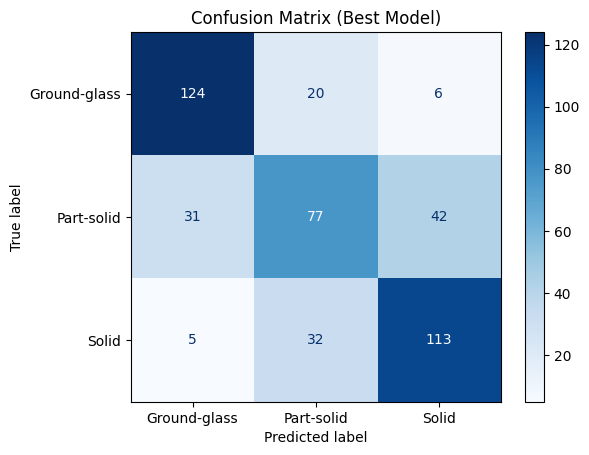

              precision    recall  f1-score   support

Ground-glass       0.78      0.83      0.80       150
  Part-solid       0.60      0.51      0.55       150
       Solid       0.70      0.75      0.73       150

    accuracy                           0.70       450
   macro avg       0.69      0.70      0.69       450
weighted avg       0.69      0.70      0.69       450



In [21]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------
# Load metadata
# -----------------------
df = pd.read_csv("../metadata/augmented_classification_metadata.csv")
df['image'] = df['image'].apply(fix_path)
df['mask'] = df['mask'].apply(fix_path)
# Load your split function if needed
def stratified_split(df, val_frac=0.15, seed=42):
    import numpy as np
    np.random.seed(seed)
    train_idxs, val_idxs = [], []
    
    for lbl in sorted(df["label_3class"].unique()):
        idxs = df[df["label_3class"] == lbl].index.values
        np.random.shuffle(idxs)
        n_val = int(len(idxs) * val_frac)
        val_idxs.extend(idxs[:n_val])
        train_idxs.extend(idxs[n_val:])
    return df.loc[train_idxs], df.loc[val_idxs]

_, val_df = stratified_split(df)

# -----------------------
# Dataset + Dataloader
# -----------------------
val_ds = NiiDataset(val_df, augment=False)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False)

# -----------------------
# Load best model
# -----------------------
checkpoint = torch.load("runs/3d_resnet/best_model.pth", map_location="cuda")
model = build_model(num_classes=3)
model.load_state_dict(checkpoint["model_state"])
model = model.to("cuda")
model.eval()

# -----------------------
# Run validation again
# -----------------------
val_targets = []
val_preds = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to("cuda")
        y = y.to("cuda")
        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        val_preds.extend(preds)
        val_targets.extend(y.cpu().numpy())

# -----------------------
# Confusion Matrix
# -----------------------
cm = confusion_matrix(val_targets, val_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Ground-glass", "Part-solid", "Solid"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Best Model)")
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

print(classification_report(val_targets, val_preds, target_names=["Ground-glass", "Part-solid", "Solid"]))



In [22]:
def get_accuracy_score(model_name,y_test, y_predicted):
  accuracy = accuracy_score(y_test, y_predicted)
  print(f"{model_name} Model Accuracy: {round(accuracy*100,2)} %")
  return round(accuracy*100,2)

def generate_classification_report(y_test, y_predicted):
  report = classification_report(y_test, y_predicted, output_dict=True)
  report_df = pd.DataFrame(report).transpose()
  return report_df

In [23]:
get_accuracy_score('ResNet18',val_targets,val_preds)

ResNet18 Model Accuracy: 69.78 %


69.78

In [24]:
generate_classification_report(val_targets,val_preds)

,precision,recall,f1-score,support
0,0.775000,0.826667,0.800000,150.000000
1,0.596899,0.513333,0.551971,150.000000
2,0.701863,0.753333,0.726688,150.000000
accuracy,0.697778,0.697778,0.697778,0.697778
macro avg,0.691254,0.697778,0.692886,450.000000
weighted avg,0.691254,0.697778,0.692886,450.000000


# Inference

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import nibabel as nib
import scipy.ndimage as ndi

from torchvision.models.video import r3d_18

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MODEL_PATH = "../models/3d_resnet/best_model.pth"  # update path
INPUT_SHAPE = (64, 64, 64)                    # expected model input (D,H,W)

LABELS = {
    0: "ground-glass",
    1: "part-solid",
    2: "solid"
}

def build_model(num_classes=3, pretrained=False):
    model = r3d_18(pretrained=pretrained)

    # modify conv1 to accept 1 channel
    old_conv = model.stem[0]
    new_conv = nn.Conv3d(
        1, old_conv.out_channels,
        kernel_size=old_conv.kernel_size,
        stride=old_conv.stride,
        padding=old_conv.padding,
        bias=False
    )

    # if pretrained weights, average channels
    if pretrained:
        new_conv.weight.data = old_conv.weight.data.mean(dim=1, keepdim=True)

    model.stem[0] = new_conv

    # replace classification head
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    return model


def load_classifier():
    model = build_model(pretrained=False).to(DEVICE)
    ckpt = torch.load(MODEL_PATH, map_location=DEVICE)

    # flexible checkpoint loading
    if "model_state" in ckpt:
        model.load_state_dict(ckpt["model_state"])
    elif "model_state_dict" in ckpt:
        model.load_state_dict(ckpt["model_state_dict"])
    else:
        model.load_state_dict(ckpt)

    model.eval()
    return model


def load_nii_patch(path):
    nii = nib.load(path)
    img = nii.get_fdata().astype(np.float32)

    # Resize only if needed
    if img.shape != INPUT_SHAPE:
        zoom = [INPUT_SHAPE[i] / img.shape[i] for i in range(3)]
        img = ndi.zoom(img, zoom, order=1)

    # Normalization (same as training: zero-mean, unit-std)
    img = (img - img.mean()) / (img.std() + 1e-8)

    # Convert to tensor shape (B, C=1, D, H, W)
    t = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).float().to(DEVICE)
    return img, t


def classify_nodule(patch_path):
    model = load_classifier()

    img_np, img_tensor = load_nii_patch(patch_path)

    with torch.no_grad():
        logits = model(img_tensor)
        probs = F.softmax(logits, dim=1)[0].cpu().numpy()

    pred_idx = int(np.argmax(probs))
    pred_label = LABELS[pred_idx]
    pred_prob = float(probs[pred_idx])

    # prepare structured output
    return {
        "predicted_class": pred_label,
        "probability": pred_prob,
        "all_probabilities": {LABELS[i]: float(probs[i]) for i in range(3)}
    }

In [26]:
patch_path = "../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279_6001_866845763956586959109892274084_1122.nii.gz"   # update this

result = classify_nodule(patch_path)

print("\n===== 3D RESNET INFERENCE RESULT =====")
print("Predicted Class:", result["predicted_class"])
print("Confidence     :", f"{result['probability']:.4f}")

print("\nFull Probabilities:")
for cls, p in result["all_probabilities"].items():
    print(f"  {cls:12s} → {p:.4f}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



===== 3D RESNET INFERENCE RESULT =====
Predicted Class: solid
Confidence     : 0.9045

Full Probabilities:
  ground-glass → 0.0246
  part-solid   → 0.0708
  solid        → 0.9045


In [27]:
def show_nii_image(nii_path):
    """
    Displays axial, coronal, and sagittal slices of a 3D NIfTI (.nii.gz) image.
    """

    import nibabel as nib
    import numpy as np
    import matplotlib.pyplot as plt

    # Load NIfTI
    img = nib.load(nii_path).get_fdata().astype(np.float32)

    # Central slices
    D, H, W = img.shape
    axial = img[D // 2]             # z-axis
    coronal = img[:, H // 2, :]     # y-axis
    sagittal = img[:, :, W // 2]    # x-axis

    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    axes[0].imshow(axial, cmap="gray")
    axes[0].set_title("Axial (Z)")
    axes[0].axis("off")

    axes[1].imshow(coronal, cmap="gray")
    axes[1].set_title("Coronal (Y)")
    axes[1].axis("off")

    axes[2].imshow(sagittal, cmap="gray")
    axes[2].set_title("Sagittal (X)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


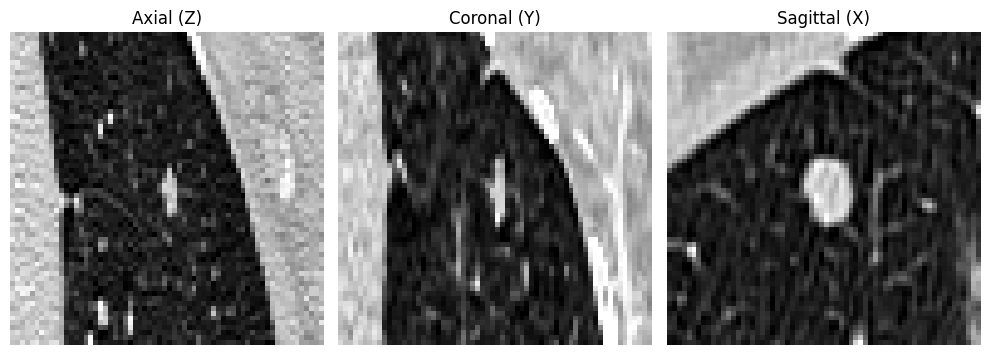

In [28]:
show_nii_image(patch_path)

===== 3D RESNET INFERENCE RESULT =====
Predicted Class: solid
Confidence     : 0.9045

Full Probabilities:
  ground-glass → 0.0246
  part-solid   → 0.0708
  solid        → 0.9045